In [1]:
from utils import *
from Visualization import *

from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import random_split

from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

%matplotlib inline


# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PyTorch Version:  2.1.2+cu121
Torchvision Version:  0.16.2+cu121


In [2]:
history =  {}

In [3]:
input_size = (256,256)
data_dir = "./data/MIT_split"

key_execution = "scale_"+str(input_size) 
history[key_execution] = {"losses": None, "acc": None }

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

batch_size = 8


In [4]:
# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}


In [5]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 1881
     Root location: ./data/MIT_split/train
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
                CenterCrop(size=(256, 256))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 807
     Root location: ./data/MIT_split/test
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
                CenterCrop(size=(256, 256))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [13]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    acc_history = {"train": [], "test": []}
    losses = {"train": [], "test": []}

    # we will keep a copy of the best weights so far according to validation accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            acc_history[phase].append(epoch_acc.item())
            losses[phase].append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, acc_history, losses

In [14]:
class Efficient_net(nn.Module):
    def __init__(self, freeze= True):
        super(Efficient_net, self).__init__()
        
        self._freeze = freeze
        
        self._eff = models.efficientnet_b0(weights="EfficientNet_B0_Weights.DEFAULT")
        
        self.features = self._eff.features
        
        self.avgpool = self._eff.avgpool
        
        self.classifier = self._eff.classifier
        
        self.gradients = None
        
        self.set_parameter_requires_grad(freeze)
        
        
    def set_parameter_requires_grad(self, feature_extracting):
        if feature_extracting:
            for param in self.parameters():
                param.requires_grad = False


    def activate_gradients(self):
        for param in self.parameters():
            param.requires_grad = True
        
    def forward(self, x):
        
        x = self.features(x)
        if not self._freeze:
            h = x.register_hook(self.activations_hook)
            self.gradients = h
            
        view = x.shape[:2]
        
        x = self.avgpool(x).view(view)
        x = self.classifier(x)
        
        return x
    
    def set_linear(self, output_size):
        self.classifier[-1] = nn.Linear(1280, output_size)
        
    def activations_hook(self, grad):
        print(grad)
        print("golaaa")
        self.gradients = grad
        
    def get_activations_gradient(self):
        return self.gradients

In [15]:
def initialize_model(num_classes):
    # Resnet18 
    model = models.efficientnet_b0(weights="EfficientNet_B0_Weights.DEFAULT")
    set_parameter_requires_grad(model, True)
    model.classifier[-1] = nn.Linear(1280,num_classes)
    #model.fc = nn.Linear(1000,num_classes)# YOUR CODE HERE!
    
    input_size = 224
        
    return model, input_size

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


# Number of classes in the dataset
num_classes = 8

# Initialize the model
model = Efficient_net()
model.set_linear(num_classes)

In [16]:
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

print(len(params_to_update))
# Observe that all parameters are being optimized

2


In [17]:
params_to_update

[Parameter containing:
 tensor([[ 0.0029, -0.0226, -0.0134,  ...,  0.0249,  0.0105, -0.0095],
         [ 0.0264, -0.0190, -0.0196,  ...,  0.0234, -0.0138,  0.0119],
         [-0.0072, -0.0137,  0.0010,  ..., -0.0053,  0.0204,  0.0060],
         ...,
         [-0.0167,  0.0145,  0.0216,  ...,  0.0241,  0.0168,  0.0186],
         [-0.0202, -0.0086,  0.0219,  ..., -0.0012,  0.0135, -0.0029],
         [-0.0141,  0.0279,  0.0037,  ...,  0.0025, -0.0008, -0.0239]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0249,  0.0224, -0.0048,  0.0209,  0.0264, -0.0180,  0.0016,  0.0186],
        requires_grad=True)]

In [11]:
#model, _ = initialize_model(8)

In [18]:
# Send the model to GPU
model = model.to(device)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Number of epochs to train for 
num_epochs = 15

optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Train and evaluate
model, hist, losses = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 1.0867 Acc: 0.7018
test Loss: 0.6097 Acc: 0.8699

Epoch 1/14
----------
train Loss: 0.6210 Acc: 0.8139
test Loss: 0.4427 Acc: 0.8736

Epoch 2/14
----------
train Loss: 0.4947 Acc: 0.8506
test Loss: 0.4082 Acc: 0.8835

Epoch 3/14
----------
train Loss: 0.4772 Acc: 0.8480
test Loss: 0.3810 Acc: 0.8823

Epoch 4/14
----------
train Loss: 0.4262 Acc: 0.8666
test Loss: 0.3385 Acc: 0.8959

Epoch 5/14
----------
train Loss: 0.3947 Acc: 0.8692
test Loss: 0.3742 Acc: 0.8761

Epoch 6/14
----------
train Loss: 0.3630 Acc: 0.8830
test Loss: 0.3154 Acc: 0.8959

Epoch 7/14
----------
train Loss: 0.3851 Acc: 0.8698
test Loss: 0.3247 Acc: 0.8971

Epoch 8/14
----------
train Loss: 0.3503 Acc: 0.8836
test Loss: 0.3246 Acc: 0.9009

Epoch 9/14
----------
train Loss: 0.3635 Acc: 0.8830
test Loss: 0.2994 Acc: 0.9033

Epoch 10/14
----------
train Loss: 0.3218 Acc: 0.8900
test Loss: 0.3080 Acc: 0.8959

Epoch 11/14
----------
train Loss: 0.3099 Acc: 0.9032
test Loss: 0.3087 Acc

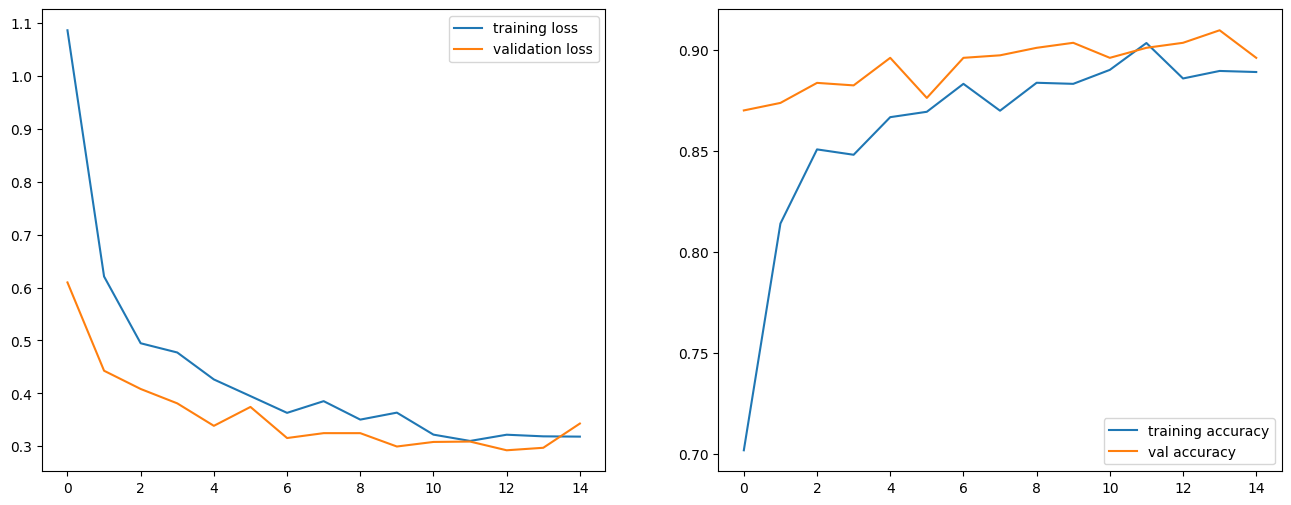

In [19]:
# plot the losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(losses["train"], label="training loss")
ax1.plot(losses["test"], label="validation loss")
ax1.legend()

ax2.plot(hist["train"],label="training accuracy")
ax2.plot(hist["test"],label="val accuracy")
ax2.legend()

plt.show()  

In [90]:
history[key_execution]["losses"] = losses
history[key_execution]["acc"] = hist


In [91]:
import pandas as pd
import seaborn as sns

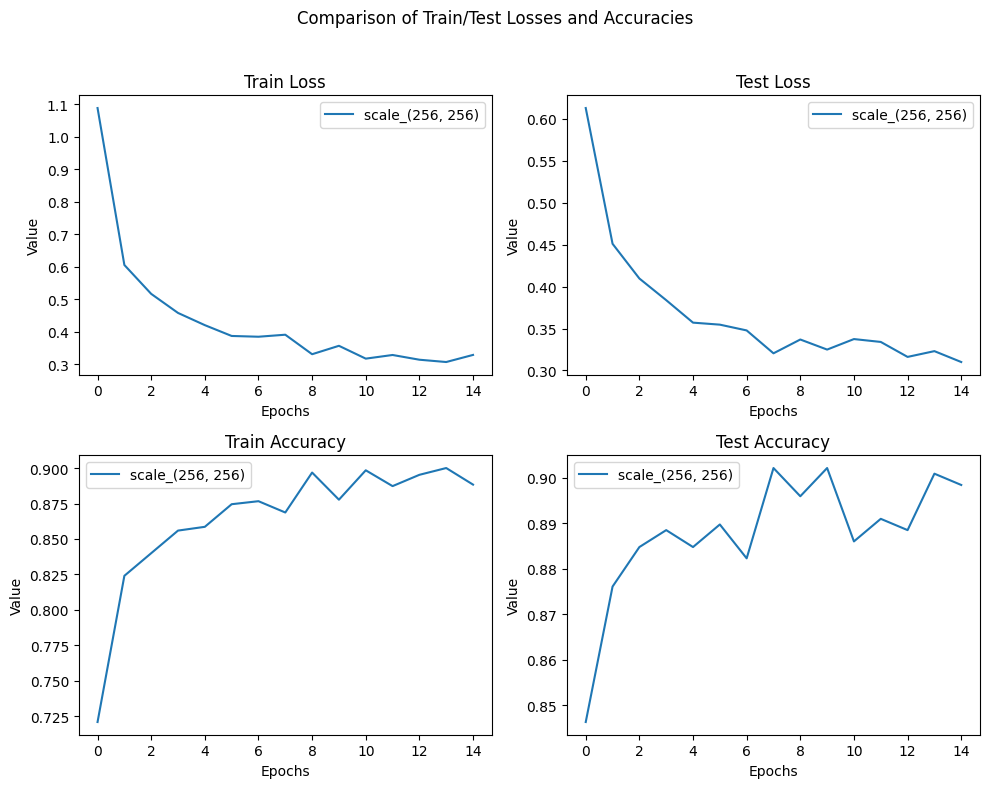

In [92]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Comparison of Train/Test Losses and Accuracies')

# Iterate over each key in the dictionary
for i, (key, values) in enumerate(history.items()):
    # Train Loss plot
    axs[0, 0].plot(values['losses']['train'], label=key)
    axs[0, 0].set_title('Train Loss')

    # Test Loss plot
    axs[0, 1].plot(values['losses']['test'], label=key)
    axs[0, 1].set_title('Test Loss')

    # Train Accuracy plot
    axs[1, 0].plot(values['acc']['train'], label=key)
    axs[1, 0].set_title('Train Accuracy')

    # Test Accuracy plot
    axs[1, 1].plot(values['acc']['test'], label=key)
    axs[1, 1].set_title('Test Accuracy')

# Add legends and labels
for ax in axs.flat:
    ax.legend()
    ax.set(xlabel='Epochs', ylabel='Value')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plots
plt.show()

## Applying GradCam

In [20]:
@torch.no_grad()  # prevent this function from computing gradients 
def get_mistakes(model, loader):
    

    val_loss = 0
    correct = 0

    model.eval()
    final_images = []
    final_targets =  []
    errors_im = []
    predictions = []

    for data, target in loader:
        data, target = data.to(device), target.to(device)
    
        output = model(data)
        p = F.softmax(output, dim=1)
        scr, pred = p.data.max(1, keepdim=True) # get the index of the max log-probability   
        
        predictions += (list(pred.cpu().numpy()))
        correct += pred.eq(target.view_as(pred)).sum().item()
        non_correcte = (pred != target.view_as(pred)).squeeze() 
        image_indexes = data[non_correcte,:,:,:]
        image_targets = target[non_correcte]
        errors = pred[non_correcte]
    
        final_images.append(image_indexes.cpu())
        final_targets.append(image_targets.cpu().numpy())
        errors_im.append(errors.cpu().numpy())

    return final_images, final_targets, errors

@torch.no_grad()  # prevent this function from computing gradients 
def validate(criterion, model, loader):
    
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    
        _, preds = torch.max(outputs, 1)
    

    
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects.double() / len(loader.dataset)
        
    print('{} Loss: {:.4f} Acc: {:.4f}'.format("test", epoch_loss, epoch_acc))




In [21]:
validate(model=model, criterion=criterion, loader=dataloaders_dict["test"])

test Loss: 0.2970 Acc: 0.9095


In [22]:
images = []
y_test = []
for i in image_datasets["test"].imgs:
    
    img = torchvision.io.read_image(i[0])
    images.append(img.float())
    y_test.append(i[-1])

images = torch.tensor(np.array(images)).to(device)
y_test = torch.tensor(np.array(y_test)).to(device)


In [23]:
images.shape

torch.Size([807, 3, 256, 256])

In [61]:
model._freeze = True
misatke_images, gt, predictions = get_mistakes(model=model, loader=dataloaders_dict["test"])

In [25]:
def tensor_to_image(img):
    img = img.permute(1, 2, 0) * 255
    img = img.numpy().astype(np.uint8)
    return img #Image.fromarray(tensor, "RGB")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


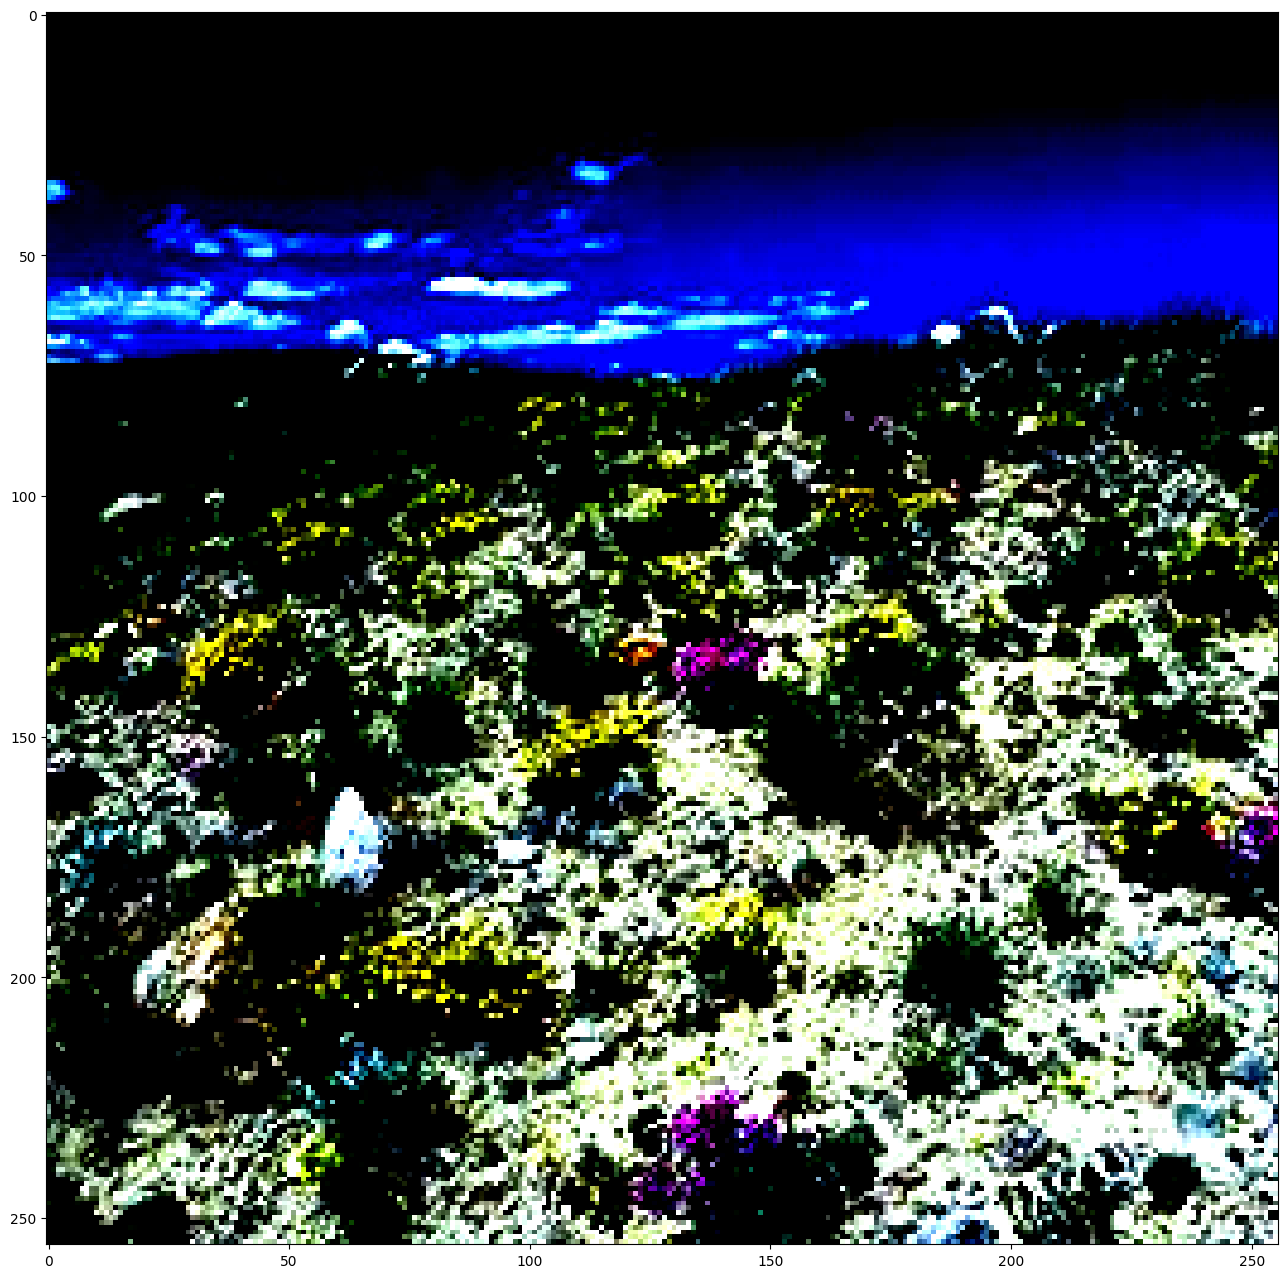

In [57]:
plt.imshow(tensor2img(misatke_images[1][0]))

In [30]:
misatke_images[1].shape

torch.Size([1, 3, 256, 256])

In [315]:
print(_[0])

tensor(0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


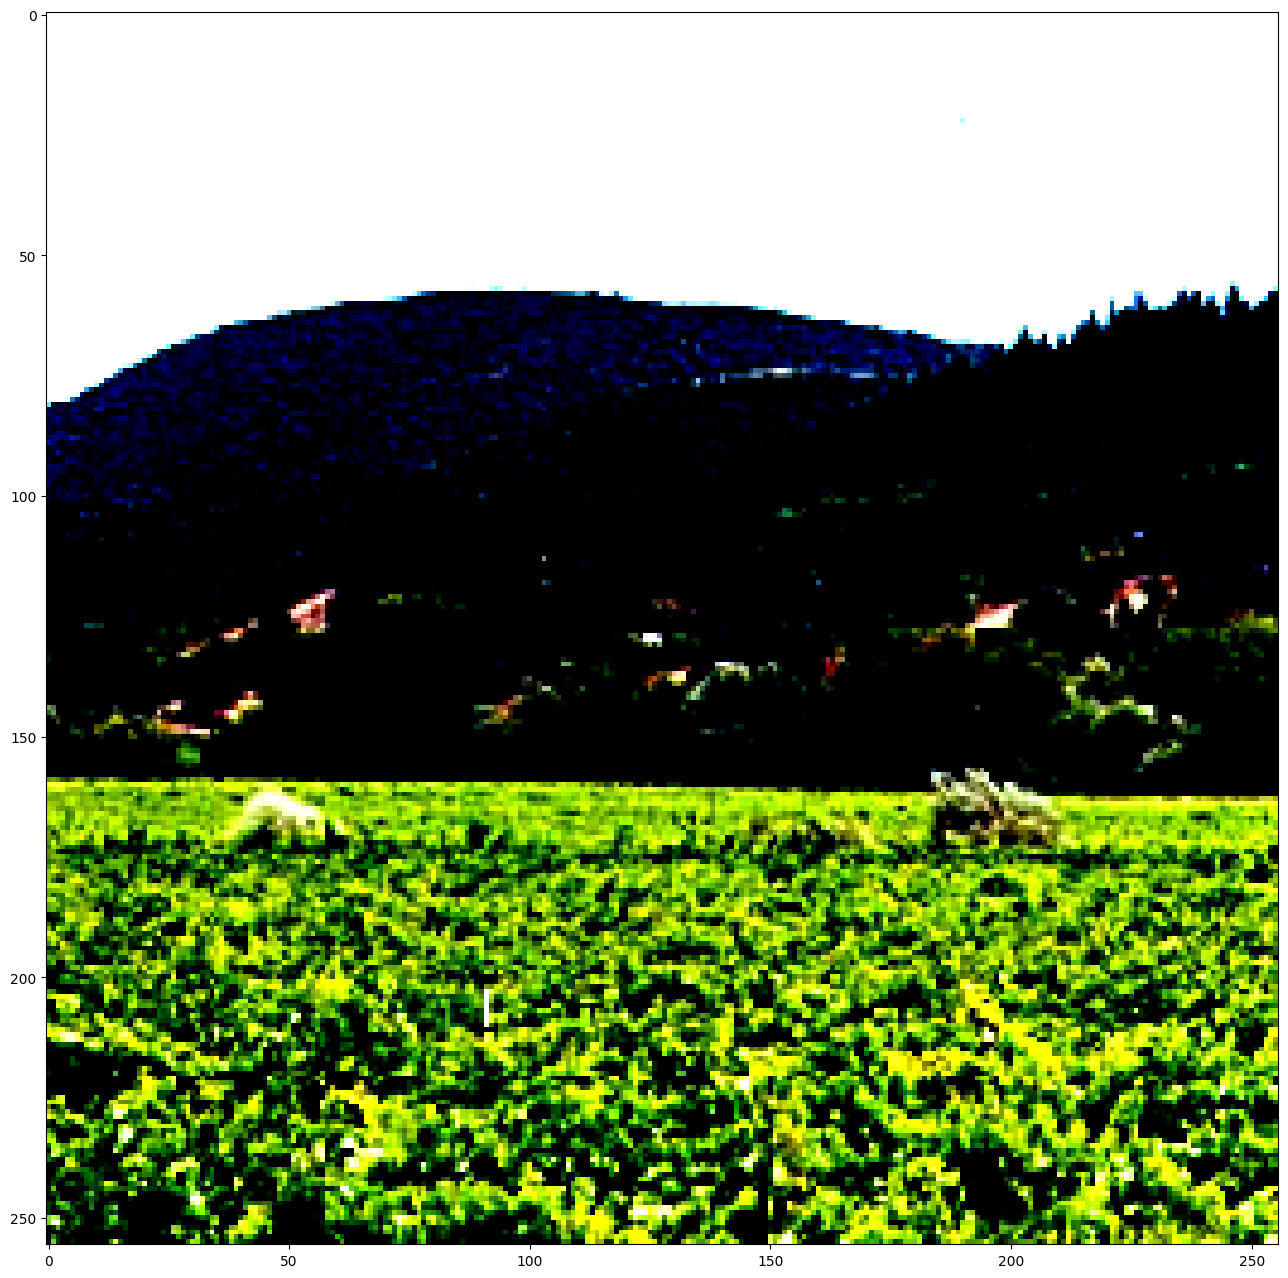

In [314]:
plt.imshow((tensor2img(img[0])))

In [36]:
print(torch.argmax(model(misatke_images[1][0].unsqueeze(0).cuda()), dim=1))

tensor([2], device='cuda:0')


In [312]:
print(_[0])

tensor(7)


In [37]:
img = misatke_images[1][0].unsqueeze(0).cuda()

In [38]:
model_traced = module2traced(model, img)

In [40]:
from Visualization.Weights import *

vis = Weights(model, device)

In [41]:
len(model_traced)

446

In [47]:
first_layer = model_traced[1]

In [48]:
first_layer

Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

In [49]:
plt.rcParams["figure.figsize"]= 16,16

In [50]:
print((img.shape))

torch.Size([1, 3, 256, 256])


torch.Size([1, 128, 128])


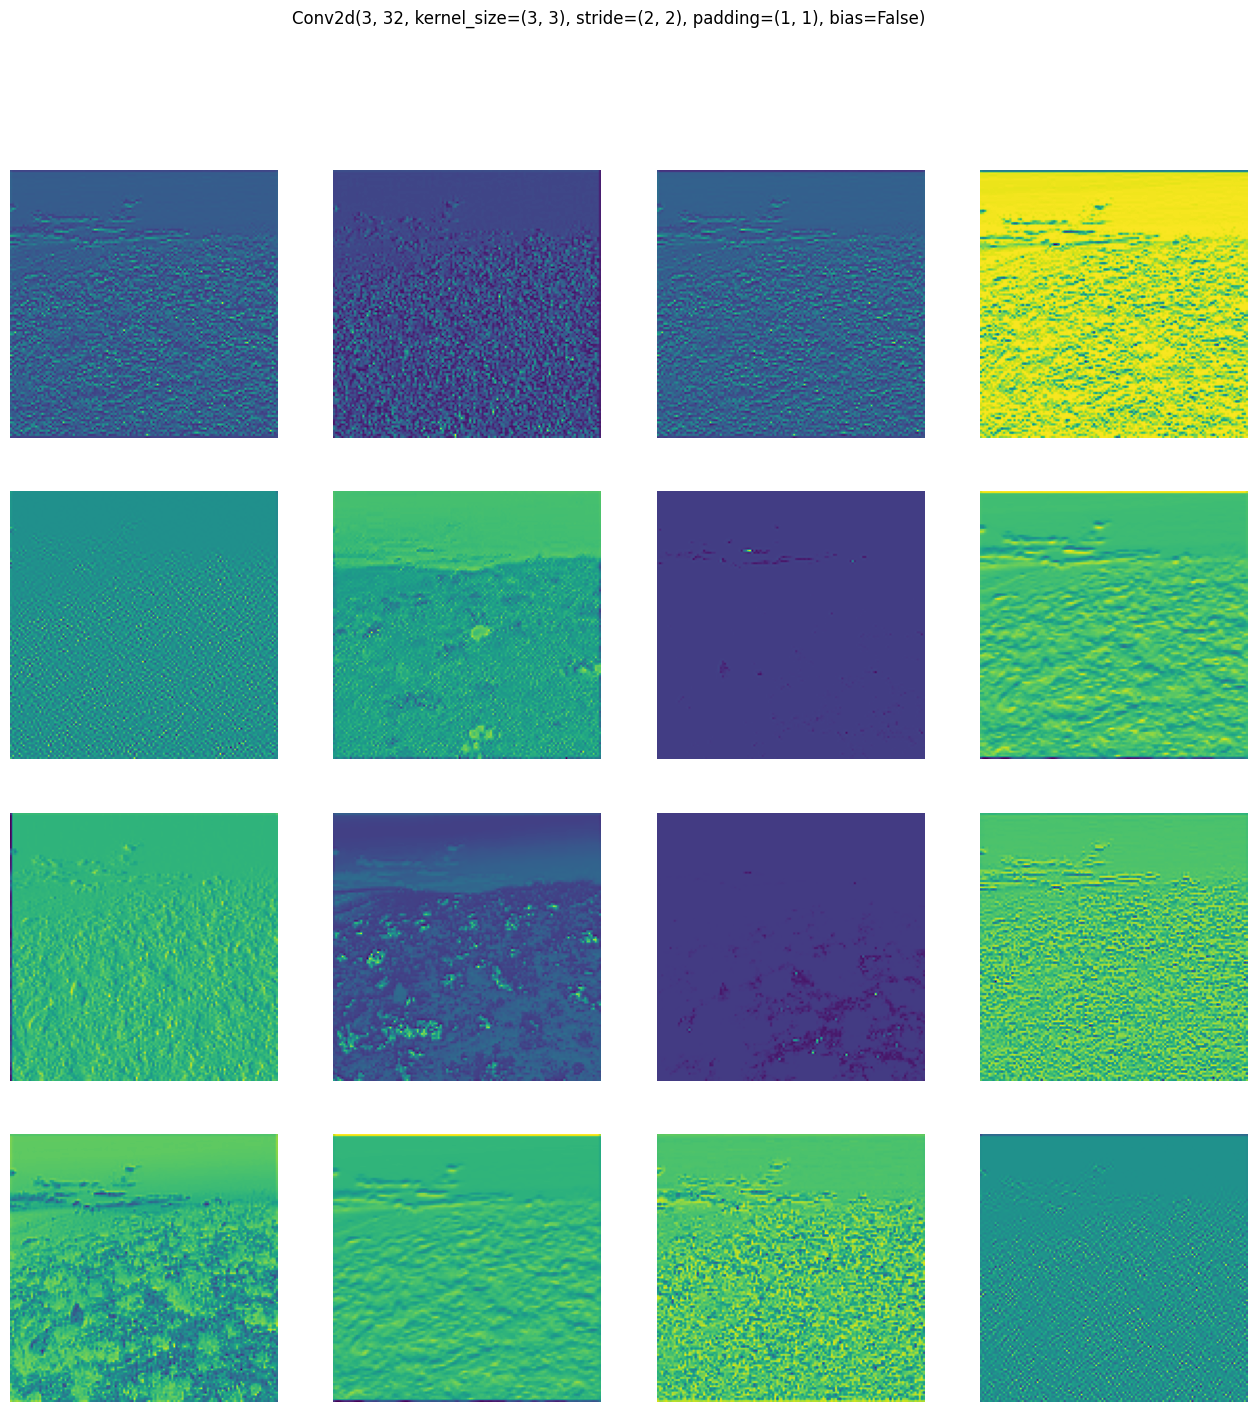

In [51]:
run_vis_plot(vis, img, first_layer, ncols=4, nrows=4)